In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

### Загрузка входных данных


In [3]:
# Функция для получение URL ссылки на файл
def get_yandex_url(public_url):
    
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    response = requests.get(api_url, params={"public_key": public_url})
    return response.json()["href"] if response.ok else None

In [4]:
# Получение URL ссылки для каждого файла
groups_url = get_yandex_url("https://disk.yandex.ru/d/UhyYx41rTt3clQ")
groups_add_url = get_yandex_url("https://disk.yandex.ru/d/5Kxrz02m3IBUwQ")
students_url = get_yandex_url("https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ")
checks_url = get_yandex_url("https://disk.yandex.ru/d/pH1q-VqcxXjsVA")

In [5]:
# Загрузка таблиц
groups = pd.read_csv(groups_url, sep=";")
groups_add = pd.read_csv(groups_add_url)
students = pd.read_csv(students_url)
checks = pd.read_csv(checks_url , sep=";")

## Выводы

В ходе анализа были проанализированны такие метрики как: 

* ARPPU - средний доход с платящего пользователя
* ARPAU - средний доход с активного пользователя
* CR - коверсия активного пользователя в покупку

Различия во всех этих метриках между группами присутвует, но не для всех метрик эти различия стат. значимые.

Для проверки стат. значимости ARPPU использовался T-тест. Использование обычного Т-теста обосновано достаточно большими выборками среди групп, несмотря на ненормальность самого распределения. Было проверено также, что распределение не является лог-нормальным, несмотря на то, что распределения доходов могут обладать такими свойствами. Тест показал стат.значимые различия среди групп.

Для проверки стат.значимости ARPAU будем использовать лишь построенный график с доверительными интервалами, из-за большого кол-ва нулей в распределении Т-тест не является надежным. Однако лишь график показывает, что доверетельные интервалы перекрываются больше чем наполовину, что означает стат. незначимые различия. 

Из формулы ARPAU = ARPPU * CR(активных пользователей) напрямую не следует, что из-за стат.значимости обоих ARPPU и CR будет стат.значимость ARPAU, однако очевидно, что если мы повышаем CR, то ARPAU также будет расти, при возрастающем ARPPU. Поэтому провдение стат. теста для конверсии активных пользователей в покупку будет более чем адекватной метрикой, чтобы понять как проявились изменения на эту группу пользователей.

Для проверки стат.значимости CR активного пользователя в покупку будем использовать критерий Хи-квадрат, переведя переменную доходы в категориальную - "купил" или "не купил". В результате группа B имеет меньшую конверсию, однако критерий Хи-квадрат показывает, что различия не стат. значимые. 

При добавлении новых значений в таблицу groups вывод по всем трем метрикам не меняется. 

**Рекомендуется запускать новую механику** оплаты для всех пользователей. Результаты имеют стат. значимые различия для пользователей, на которые нацелено это изменение, а именно **платящие пользователи**. Результат анализа выстраиваются в логическую рамку, где на просто активных пользователей изменение не имеет никого значения, потому что не все из них доходят до экрана оплаты. Однако для пользователей, которые непосредственно пользуются новой фичей, а именно платящие пользователи, их средние расходы растут, скорее всего из-за более гибкого выбора в оплате.

### Предобработка данных

#### Общая информация о данных

In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [9]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


#### Проверка на наличие NULL значений

In [10]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
students.isna().sum()

student_id    0
dtype: int64

In [13]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Нулевых значений в данных нет

#### Проверка на наличие дубликатов в данных

In [14]:
groups[groups.duplicated()]

,id,grp


In [15]:
students[students.duplicated()]

,student_id


In [16]:
groups_add[groups_add.duplicated()]

,id,grp


In [17]:
checks[checks.duplicated()]

,student_id,rev


Дубликатов в данных нет

#### Проверка отрицательных и нулевых значений в столбце с доходами

In [18]:
checks[checks.rev <= 0]

,student_id,rev


Все значения положительные

#### Визуализация выбросов в колонке с доходами

1610.0


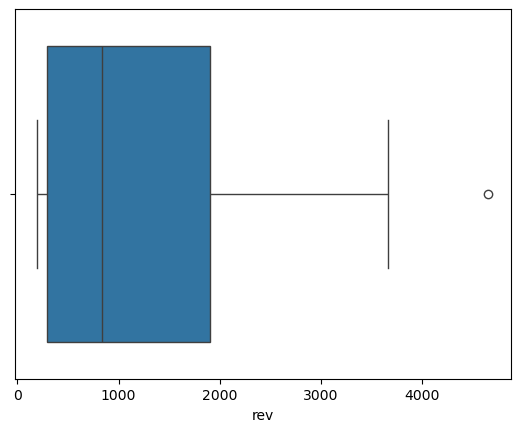

In [19]:
sns.boxplot(x=checks["rev"])  # Визуализация выбросов
Q1 = checks["rev"].quantile(0.25)
Q3 = checks["rev"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#### Удаление выбросов по межквартильному размаху

In [20]:
checks = checks[(checks['rev'] >= Q1 - 1.5*IQR) & 
                (checks['rev'] <= Q3 + 1.5*IQR)]

<Axes: xlabel='rev'>

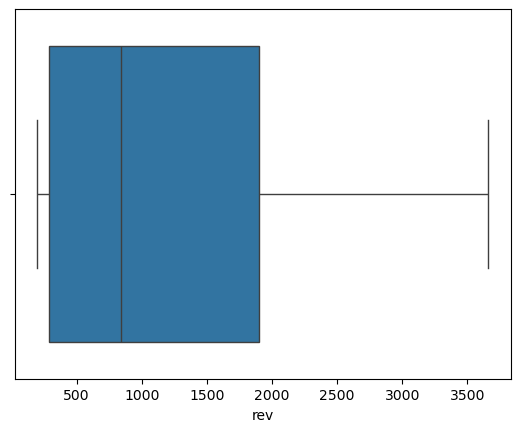

In [21]:
sns.boxplot(x=checks["rev"])

## Подсчет метрик

### ARPPU - средний доход с платящего пользователя

In [22]:
# INNER JOIN объединение groups с checks, 
# так как нас интересуют только платящие
ARPPU = groups.merge(checks, left_on="id", right_on="student_id")

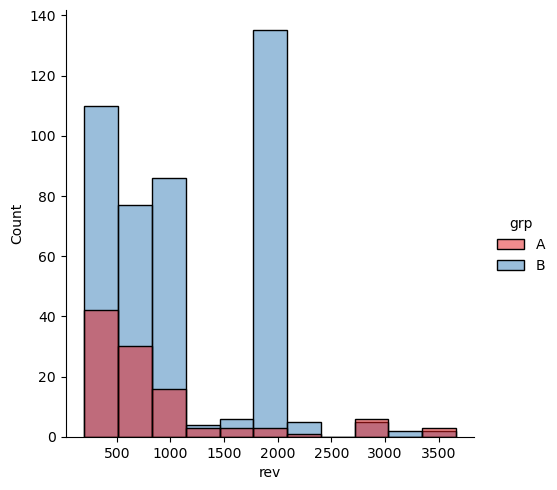

In [23]:
# Распределение ARPPU по группам 
sns.set_palette("Set1")
sns.displot(data=ARPPU, x="rev", hue="grp")

<Axes: xlabel='grp', ylabel='rev'>

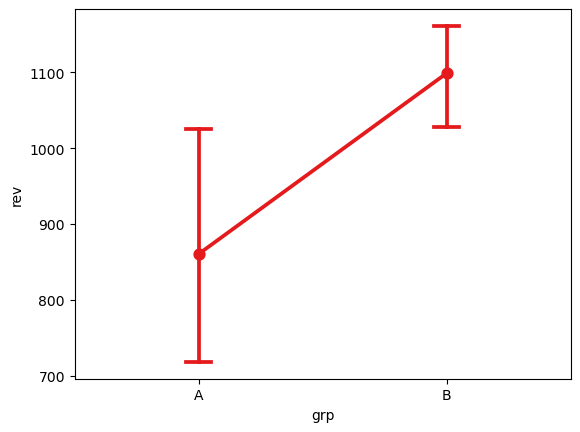

In [24]:
# Сравнение средних ARPPU между двумя группами на графике
sns.pointplot(x="grp", y="rev", data=ARPPU, capsize=0.1)

#### Проверка гипотез 

- **H0** - Средние значения ARPPU в двух группах равны
- **H1** - Средние значения ARPPU в двух группах не равны

#### ARPPU определение стат. значимости различий

In [25]:
# Разделяем группы на контрольную и целевую
control = ARPPU.query("grp == 'A'")["rev"]
test = ARPPU.query("grp == 'B'")["rev"]

In [26]:
#Проверка, не содержат ли группы, одинаковых student_id
common_ids = ARPPU.query(
    "grp == 'B'")["student_id"].isin(ARPPU.query("grp == 'A'")["student_id"])
common_ids.sum()

np.int64(0)

Группы содержат разных студентов

#### Тест на нормальность

In [27]:
# Тест Шапиро-Уилка
print(st.shapiro(control))
print(st.shapiro(test))

ShapiroResult(statistic=np.float64(0.7196124408128413), pvalue=np.float64(5.321662581039505e-13))
ShapiroResult(statistic=np.float64(0.8711369504507026), pvalue=np.float64(1.863114629641849e-18))


Распределения доходов ненормально, что характерно для распределения доходов. Однако проверим является ли оно лог.нормальным

#### Проверка лог-нормальности распределения

In [28]:
# Тест Шапиро-Уилка
print(st.shapiro(np.log(control)))
print(st.shapiro(np.log(test)))

ShapiroResult(statistic=np.float64(0.9208947803901671), pvalue=np.float64(8.371042413410196e-06))
ShapiroResult(statistic=np.float64(0.8908507981003235), pvalue=np.float64(5.644641611683388e-17))


Распределения также не является лог.нормальным. Однако стат. значимость будем 
проверять T-тестом, несмотря на ненормальность распределения, так как размер обеих выборок больше 30 и выборочные средние по ЦПТ будут распределены близко к нормальному. 

#### Проверка равенства дисперсий

Для коректного примения T-теста нужно узнать о гомоскедастичности дисперсий

In [29]:
st.levene(control, test)

LeveneResult(statistic=np.float64(3.8180591715750443), pvalue=np.float64(0.05122163607985061))

Принимаем нулевую гипотезу теста Левена, а том что дисперсии групп равны

#### T-тест

In [30]:
st.ttest_ind(control, test, equal_var=True)

TtestResult(statistic=np.float64(-2.9715175016887327), pvalue=np.float64(0.003096076192435707), df=np.float64(537.0))

Тест показал стат.значимые различия

### ARPAU - средний доход с активного пользователя

In [31]:
# LEFT JOIN students с checks, чтобы знать, кто из активных платил
ARPAU = students.merge(checks, how="left", on="student_id")
# Заполняем nan значения 0,так как они ничего не покупали
ARPAU.fillna(0, inplace=True)
# INNER JOIN с groups для принадлежности студента к группе
ARPAU = ARPAU.merge(groups, left_on="student_id", right_on="id")

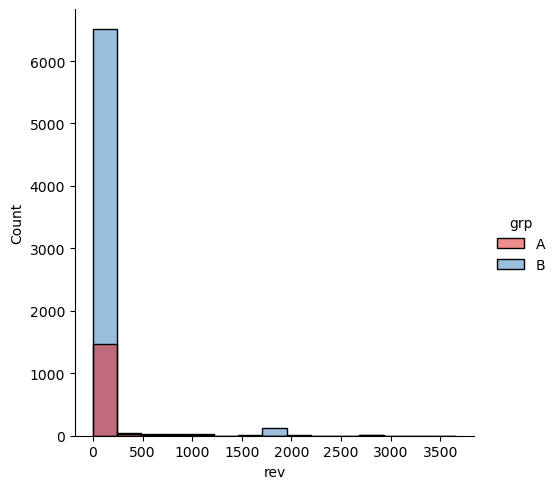

In [32]:
# Распределение ARPAU по группам 
sns.displot(data=ARPAU, x="rev", hue="grp")

In [33]:
#Проверка, не содержат ли группы, одинаковых student_id
common_ids = ARPAU.query(
    "grp == 'B'")["student_id"].isin(ARPAU.query("grp == 'A'")["student_id"])
common_ids.sum()

np.int64(0)

Группы содержат разных студентов

<Axes: xlabel='grp', ylabel='rev'>

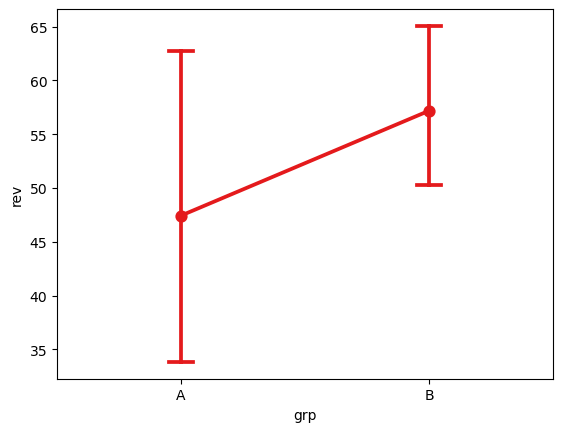

In [34]:
# постороение ARPAU графика 
sns.pointplot(x="grp", y="rev", data=ARPAU, capsize=0.1)

Из-за особенности распределения ARPAU(большого кол-ва нулей в начале), стат.тест не может быть надежным в данном случае. Поэтому ограничимся рассмотрением доверительных интервалов. На графике усы интервалов пересекаются больше чем наполовину(интервал группы B почти полностью лежит в интервале группы A), поэтому можно говорить о стат.незначимости различий.

Но так как нас больше интересует как ведут себя активные пользователи(стали ли они больше покупать?), нежели денежное выражение, провдение стат. теста для конверсии активных пользователей в покупку будет более чем адекватной метрикой, чтобы понять как проявились изменения на эту группу пользователей. 

Из формулы ARPAU = ARPPU * CR(активных пользователей) напрямую не следует, что из-за стат.значимости обоих ARPPU и CR будет стат.значимость ARPAU, однако очевидно, что если мы повышаем CR, то ARPAU также будет расти, при возрастающем ARPPU.

### CR активных пользователей в покупку

In [35]:
# LEFT JOIN students с checks, чтобы знать, кто из активных платил
CR_active = students.merge(checks, how="left", on="student_id")
# Добавление колонки, которая превращает rev в категореальную переменную
# 1-платил, 0-неплатил
CR_active = CR_active.assign(
    cr_active_to_buy=CR_active.rev.map(lambda x: 0 if np.isnan(x) else 1))
# INNER JOIN с groups для принадлежности студента к группе
CR_active = CR_active.merge(groups, left_on="student_id", right_on="id")

<Axes: xlabel='cr_active_to_buy', ylabel='count'>

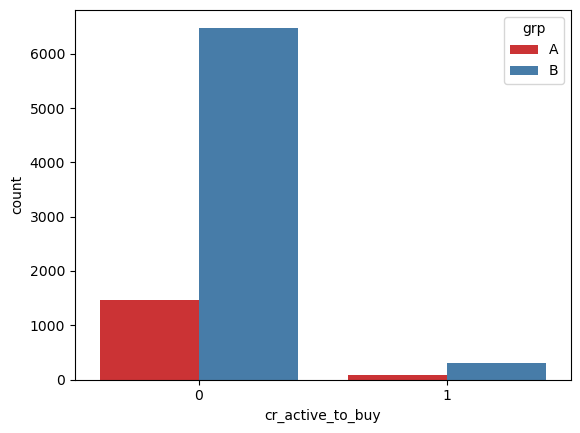

In [36]:
#Соотношение действий пользователя в разных группах
sns.countplot(data=CR_active, x="cr_active_to_buy", hue="grp")

<Axes: xlabel='grp', ylabel='cr_active_to_buy'>

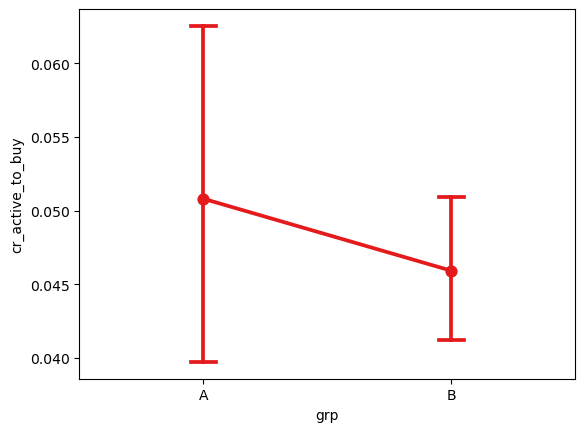

In [37]:
# Сравнение CR конверсии активных пользователей в покупку в двух группах
sns.pointplot(
    x="grp", y="cr_active_to_buy", 
    data=CR_active, estimator=np.mean, capsize=0.1, order=["A", "B"])

#### Провека гипотез:
- **H0** - Доля пользователей, совершивших покупку, одинакова в контрольной и тестовой группах
- **H1** - Доля пользователей, совершивших покупку, различается между контрольной и тестовой группами

#### Хи-квадрат тест CR в покупку активных пользователей

In [38]:
# Создаём таблицу сопряжённости с помощью crosstab
cross_tab = pd.crosstab(CR_active["grp"], CR_active["cr_active_to_buy"])

In [39]:
cross_tab

cr_active_to_buy,0,1
grp,,
A,1457,78
B,6481,312


In [40]:
# Тест Хи-квадрат
chi2, p, dof, expected = st.chi2_contingency(cross_tab)
print(f"Хи-квадрат: {chi2:.3f}")
print(f"P-значение: {p:.3f}")
print(f"Степени свободы: {dof}")
print("Ожидаемые частоты:\n", expected)

Хи-квадрат: 0.564
P-значение: 0.453
Степени свободы: 1
Ожидаемые частоты:
 [[1463.11599424   71.88400576]
 [6474.88400576  318.11599424]]


Получили статистически незначимые результаты для разницы конверсий в двух группах. Конверсия в группе B оказалась ниже, чем в A, однако мы не можем отклонить нулевую гипотезу.

### Функции

In [41]:
def recalculate_metrics(public_url):
    
    try:
        # Считывание файла
        new_rows = pd.read_csv(get_yandex_url(public_url))
        new_groups = (pd.concat([groups, new_rows], ignore_index=True)
                        .drop_duplicates())
        
        # Подсчет метрики ARPPU
        new_ARPPU = new_groups.merge(
            checks, left_on='id', right_on='student_id')
        metrics = (new_ARPPU.groupby("grp", as_index=False)
                            .agg(ARPPU = ("rev","mean")))
        # Подсчет метрики ARPAU
        new_ARPAU = students.merge(checks, how="left", on="student_id")
        new_ARPAU.fillna(0, inplace=True)
        new_ARPAU = new_ARPAU.merge(
            new_groups, left_on="student_id", right_on="id")
        new_ARPAU = (new_ARPAU.groupby("grp", as_index=False)
                              .agg(ARPAU=("rev", "mean")))
        # Подсчет метрики CR активных пользователей в покупку
        new_CR_active = students.merge(checks, how="left", on="student_id")
        new_CR_active = new_CR_active.assign(
            cr_active_to_buy=(new_CR_active.rev
                              .map(lambda x: 0 if np.isnan(x) else 1)))
        new_CR_active = new_CR_active.merge(
            new_groups, left_on="student_id", right_on="id")
        new_CR_active = (new_CR_active.groupby("grp", as_index=False)
                            .agg(CR_active=("cr_active_to_buy", "mean")))
        
        # Объединение результатов в одну таблицу
        metrics = (metrics.merge(new_ARPAU, on="grp")
                          .merge(new_CR_active, on="grp"))
        
        
        return metrics
               
        
    except FileNotFoundError:
        return {"error": "Файл не найден"}
    except Exception as e:
        return {"error": f"Произошла ошибка: {str(e)}"}

In [42]:
recalculate_metrics("https://disk.yandex.ru/d/5Kxrz02m3IBUwQ")

,grp,ARPPU,ARPAU,CR_active
0,A,860.71028,47.347204,0.050715
1,B,1100.64666,57.375276,0.046009


In [43]:
def redraw_metrics(public_url):
    
    try:
        new_rows = pd.read_csv(get_yandex_url(public_url))
        new_groups = (pd.concat([groups, new_rows], ignore_index=True)
                      .drop_duplicates())
        # Создание осей для графика
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
        
        # Построение графика ARPPU
        new_ARPPU = new_groups.merge(
            checks, left_on='id', right_on='student_id')
        sns.pointplot(
            data=new_ARPPU, x="grp", y="rev", ax=axes[0], order=["A", "B"])
        
        # Построение графика ARPAU
        new_ARPAU = students.merge(checks, how="left", on="student_id")
        new_ARPAU.rev.fillna(0, inplace=True)
        new_ARPAU = new_ARPAU.merge(
            new_groups, left_on="student_id", right_on="id")
        sns.pointplot(
            data=new_ARPAU, x="grp", y="rev", ax=axes[1], order=["A", "B"])
        
        # Подсчет метрики CR активных пользователей в покупку
        new_CR_active = students.merge(checks, how="left", on="student_id")
        new_CR_active = new_CR_active.assign(
            cr_active_to_buy = new_CR_active.rev.map(
                lambda x: 0 if np.isnan(x) else 1))
        new_CR_active = new_CR_active.merge(
            new_groups, left_on="student_id", right_on="id")
        sns.pointplot(
            data=new_CR_active, x="grp", 
            y="cr_active_to_buy", ax=axes[2], order=["A", "B"])
        
        axes[0].set_title('ARPPU')
        axes[1].set_title('ARPAU')
        axes[2].set_title('CR активных пользователей в покупку')


        plt.tight_layout()

               
        
    except FileNotFoundError:
        return {"error": "Файл не найден"}
    except Exception as e:
        return {"error": f"Произошла ошибка: {str(e)}"}

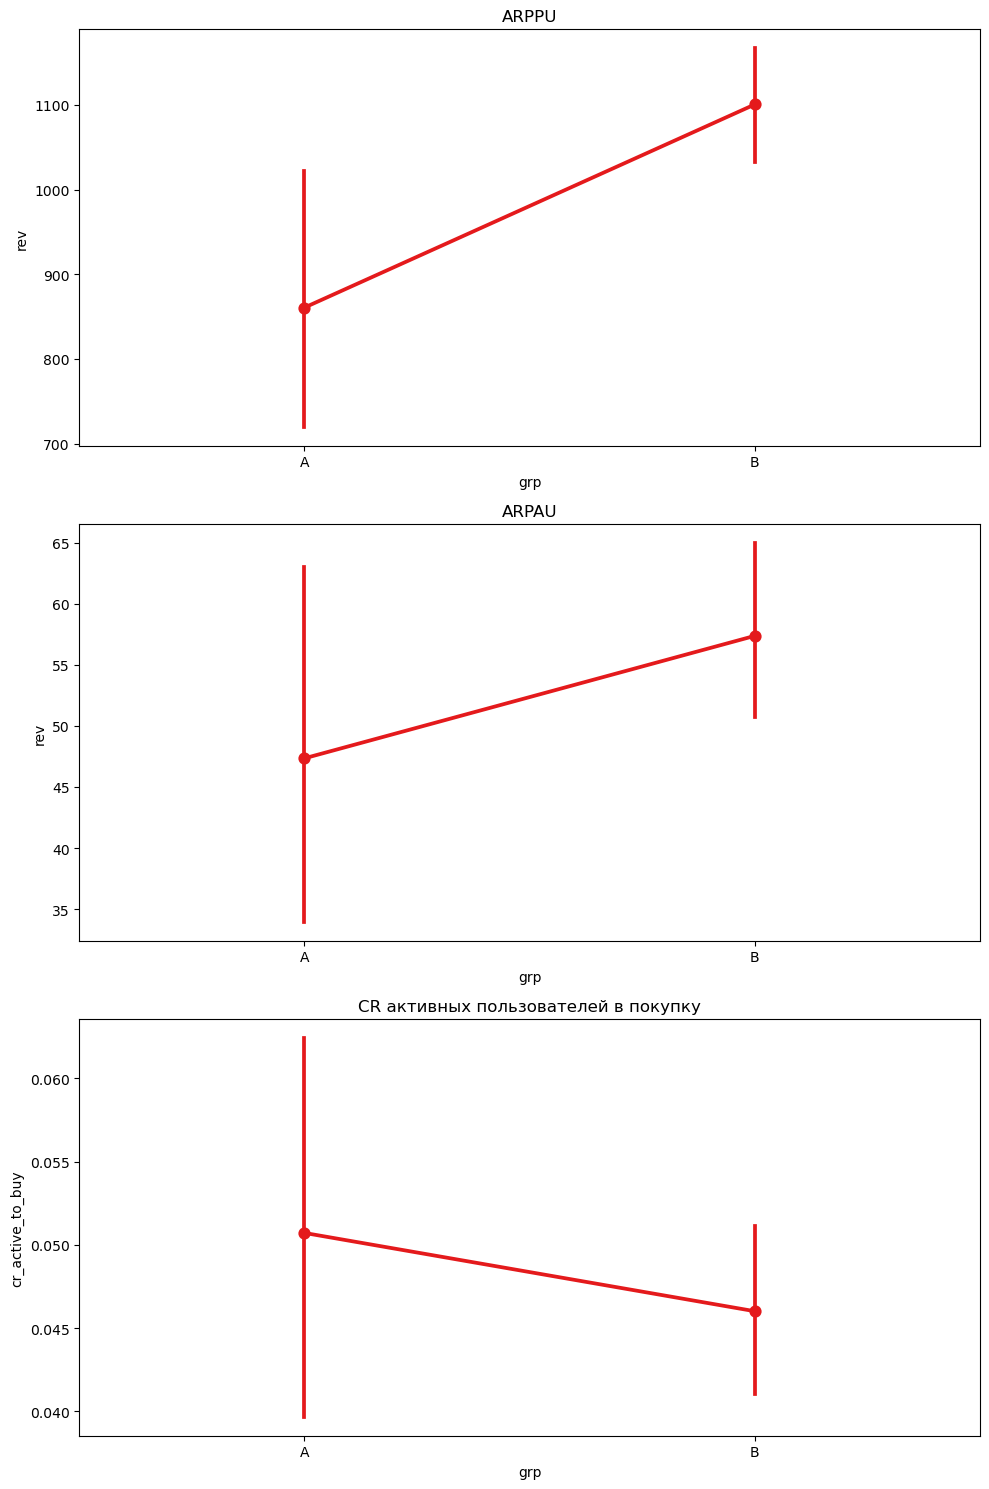

In [44]:
redraw_metrics("https://disk.yandex.ru/d/5Kxrz02m3IBUwQ")

### Стат.тест после добавления групп

In [45]:
new_rows = pd.read_csv(groups_add_url)

In [46]:
new_groups = pd.concat(
    [groups, new_rows], ignore_index=True).drop_duplicates()

### Пересчет ARPPU

In [47]:
new_ARPPU = new_groups.merge(checks, left_on="id", right_on="student_id")

In [48]:
# Разделяем группы на контрольную и целевую
control = new_ARPPU.query("grp == 'A'")["rev"]
test = new_ARPPU.query("grp == 'B'")["rev"]

In [49]:
print(st.shapiro(control))
print(st.shapiro(test))

ShapiroResult(statistic=np.float64(0.7196124408128413), pvalue=np.float64(5.321662581039505e-13))
ShapiroResult(statistic=np.float64(0.8709938273791386), pvalue=np.float64(1.728362812718737e-18))


Распределены не нормально

In [50]:
print(st.shapiro(np.log(control)))
print(st.shapiro(np.log(test)))

ShapiroResult(statistic=np.float64(0.9208947803901671), pvalue=np.float64(8.371042413410196e-06))
ShapiroResult(statistic=np.float64(0.8902525262927441), pvalue=np.float64(4.814894374022284e-17))


Распределены не лог нормально

In [51]:
st.levene(control, test)

LeveneResult(statistic=np.float64(3.9199627990889434), pvalue=np.float64(0.04822507285703676))

Дисперсии не равны

In [52]:
st.ttest_ind(control, test, equal_var=False)

TtestResult(statistic=np.float64(-2.7839381389893743), pvalue=np.float64(0.006063619969483077), df=np.float64(149.7252844945083))

Стат.значемые результаты

### Пересчет CR активных пользователей в покупку

In [53]:
# Используем новую обновленную таблицу groups
new_CR_active = students.merge(checks, how="left", on="student_id")
new_CR_active = new_CR_active.assign(
    cr_active_to_buy=new_CR_active.rev.map(
        lambda x: 0 if np.isnan(x) else 1))
new_CR_active = new_CR_active.merge(
    new_groups, left_on="student_id", right_on="id")

In [54]:
# Создаём таблицу сопряжённости с помощью crosstab
cross_tab = pd.crosstab(
    new_CR_active["grp"], new_CR_active["cr_active_to_buy"])

In [55]:
cross_tab

cr_active_to_buy,0,1
grp,,
A,1460,78
B,6490,313


In [56]:
chi2, p, dof, expected = st.chi2_contingency(cross_tab)
print(f"Хи-квадрат: {chi2:.3f}")
print(f"P-значение: {p:.3f}")
print(f"Степени свободы: {dof}")
print("Ожидаемые частоты:\n", expected)

Хи-квадрат: 0.521
P-значение: 0.470
Степени свободы: 1
Ожидаемые частоты:
 [[1465.9033689   72.0966311]
 [6484.0966311  318.9033689]]


Стат. незначимые результаты